In [1]:
# import libraries
import pandas as pd
import spacy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tomotopy as tp
import nltk

In [2]:
# import data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
train.head()

,helpfulness_cat,imdb_user_review
0,1.0,It is hard to find such delightful and adorabl...
1,1.0,"They don't make films like this faded, hauntin..."
2,1.0,I first viewed this movie in 1924 at age 6 yrs...
3,1.0,I doubt that I'd ever seen anything resembling...
4,1.0,I was shocked to find myself riveted to this m...


In [4]:
print(sum(train['helpfulness_cat'])/len(train))


0.7637377963737796


In [5]:
document_lengths = np.array(list(map(len, train['imdb_user_review'].str.split(' '))))

print("The average number of words in a document is: {}.".format(np.mean(document_lengths)))
print("The minimum number of words in a document is: {}.".format(min(document_lengths)))
print("The maximum number of words in a document is: {}.".format(max(document_lengths)))

The average number of words in a document is: 175.48888888888888.
The minimum number of words in a document is: 6.
The maximum number of words in a document is: 3954.


/Users/crystal_wong/opt/anaconda3/envs/SMM694/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'Distribution of number of words'}, xlabel='Number of words', ylabel='Density'>

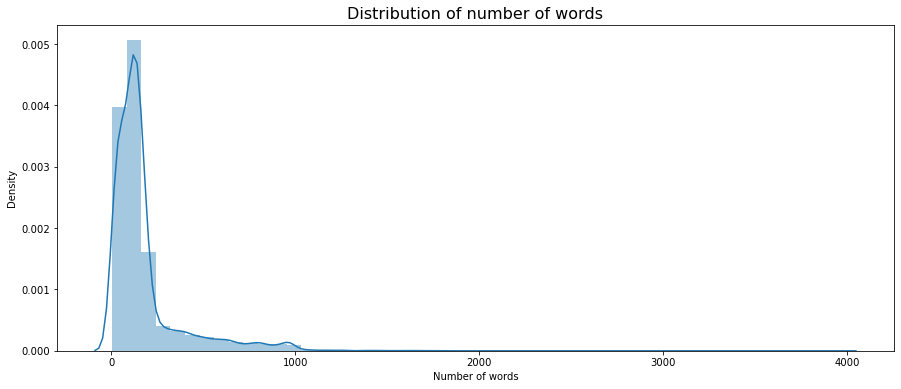

In [6]:
fig, ax = plt.subplots(figsize=(15,6))

ax.set_title("Distribution of number of words", fontsize=16)
ax.set_xlabel("Number of words")
sns.distplot(document_lengths, bins=50, ax=ax)

In [7]:
print("There are {} documents with over 1500 words.".format(sum(document_lengths > 1500)))
print("There are {} documents with max 6 words.".format(sum(document_lengths <= 6)))

There are 9 documents with over 1500 words.
There are 2 documents with max 6 words.


### Basic Data Cleansing

In [8]:
import re

In [9]:
# data sample
train['imdb_user_review'][50]

'The Forties were the years when Hollywood decided that the mystery thriller deserved big-budget, big-star treatment, threw up a new kind of hero who was exactly right for his time: they were the fabulous years which established the private eye adventure as the irremovable all-time favorite in the whole field of suspense\\u0085 The field was so rich, the choice so lavish in that decade, that it was difficult to know where memory should stop and call \\"Encore\\".As the author of the screenplay, Huston made every effort to do justice, and remain faithful, to Dashiell Hammett\'s novel\\u0085 But in remaining faithful, the newest version asked audiences to accept the complicated plot at its full strength and that is where the film\'s main flaw occurs\\u0085 Names, murders, and intrigues turn up so quickly that it is extremely difficult to understand exactly what is happening in this tale of an assortment of characters in search of a fabulous jewel-encrusted statue\\u0085 Probably in no ot

In [18]:
def basic_clean(text):
    """
    Remove \\,\n,\t,... from text
    Remove whitespace from text
    change to lowercase
    """
    
    # Replacing all the occurrences of \n,\\n,\t,\\ with a space.
    Formatted_text = text.replace('\\n', ' ').replace('\n', ' ').replace('\t',' ').replace('\'', ' ').replace('"',' ')
    pattern = re.compile(r'\s+')
    Formatted_text = Formatted_text.lower()
    Formatted_text = Formatted_text.replace('\\u00b4',"").replace('\\','')
    Without_whitespace = re.sub(pattern, ' ', Formatted_text)
    Formatted_text = Without_whitespace.replace('?', ' ? ').replace(')', ') ')
    return Formatted_text

In [19]:
# cleaning data
train['imdb_user_review'] = train['imdb_user_review'].apply(basic_clean)
train['imdb_user_review'][50]

'the forties were the years when hollywood decided that the mystery thriller deserved big-budget, big-star treatment, threw up a new kind of hero who was exactly right for his time: they were the fabulous years which established the private eye adventure as the irremovable all-time favorite in the whole field of suspenseu0085 the field was so rich, the choice so lavish in that decade, that it was difficult to know where memory should stop and call encore .as the author of the screenplay, huston made every effort to do justice, and remain faithful, to dashiell hammett s novelu0085 but in remaining faithful, the newest version asked audiences to accept the complicated plot at its full strength and that is where the film s main flaw occursu0085 names, murders, and intrigues turn up so quickly that it is extremely difficult to understand exactly what is happening in this tale of an assortment of characters in search of a fabulous jewel-encrusted statueu0085 probably in no other film will a

In [20]:
len(train)

10755

In [100]:
train['review_length'] = np.array(list(map(len, train['imdb_user_review'].str.split(' '))))

,helpfulness_cat,imdb_user_review,review_length
0,1.0,it is hard to find such delightful and adorabl...,135
1,1.0,"they don t make films like this faded, hauntin...",378
2,1.0,i first viewed this movie in 1924 at age 6 yrs...,53
3,1.0,i doubt that i d ever seen anything resembling...,176
4,1.0,i was shocked to find myself riveted to this m...,123
...,...,...,...
10750,0.0,the makers of this movie really touched a sore...,123
10751,0.0,i care a lot is an exhilarating black comedy w...,44
10752,0.0,really loved this. this film is masterful in t...,31
10753,0.0,"the story, direction and acting across the boa...",25


In [101]:
unhelpful = train.loc[train["helpfulness_cat"] == 0, ["imdb_user_review", "helpfulness_cat", "review_length"]]
helpful = train.loc[train["helpfulness_cat"] == 1, ["imdb_user_review", "helpfulness_cat", "review_length"]]
helpful = helpful.sample(n=len(unhelpful), random_state=42)
s = pd.concat([unhelpful, helpful]) # create a more balanced training set for training the model

LDA

In [102]:
nlp = spacy.load("en_core_web_sm")
docs = nlp.pipe(
    s.loc[:, "imdb_user_review"].str.lower(),
    n_process=2, 
    batch_size=500, 
    disable=["tok2vec"],
)
tkns_docs = []
for doc in docs:
    tmp = []
    for token in doc:
        if (
            token.is_stop == False
            and token.is_punct == False
            and token.like_num == False
            and token.is_space == False
        ):
            tmp.append(token.lemma_)
    tkns_docs.append(tmp)
    del tmp

#### bigram and trigram

In [103]:
import gensim
from gensim.models.phrases import Phrases, ENGLISH_CONNECTOR_WORDS

In [105]:
# Build the bigram and trigram models
bigram = Phrases(tkns_docs, min_count=5, threshold=50, connector_words=ENGLISH_CONNECTOR_WORDS) # higher threshold fewer phrases.
trigram = Phrases(bigram[tkns_docs], threshold=50, connector_words=ENGLISH_CONNECTOR_WORDS)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[tkns_docs[0]]])

['movie', 'best', 'described', 'pathetic', 'good', 'people', 'today', 'sound', 'appeared', 'films', 'wonder', 'film', 'high', 'ratings', 'galactic', 'effort', 'sit', 'metropolis', 'complete_waste', 'time', 'dialogues', 'appeared', 'films', 'single', 'film', 'considered', 'good', 'good', 'dialogues', 'films', 'imdb', 'list', 'single', 'film', 'won', 'place', 'run_mill', 'dialogues', 'sound', 'today', 's', 'audience', 'wants', 'story', 'strong', 'dialogue', 'good', 'acting', 'effects', 'acting', 'stiff', 'fashion', 'metroplis', 'excessive', 'use', 'expressions', 'lack', 'sound', 'understandable', 'today', 'looks', 'bit', 'funny', 'recommendation', 'don_t_watch']


In [106]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [107]:
# form bigrams
tkns_docs = make_bigrams(tkns_docs)
# form trigrams
tkns_docs = make_trigrams(tkns_docs)

In [61]:
corpus = tp.utils.Corpus()
for item in tkns_docs:
    corpus.add_doc(words=item)
mf = {}
for i in range(20, 200, 20):
    print(
        ">>> Working on the model with {} topics >>>\n".format(i),
        flush=True
    )
    mdl = tp.LDAModel(k=i, corpus=corpus, min_df=5, rm_top=5, seed=42)
    mdl.train(0)
    for j in range(0, 800, 10):
        mdl.train(10)
        print("Iteration: {}\tLog-likelihood: {}".format(j, mdl.ll_per_word))
    coh = tp.coherence.Coherence(mdl, coherence="u_mass")
    mf[i] = coh.get_score()
    mdl.save("k_{}".format(i), True)

>>> Working on the model with 20 topics >>>

Iteration: 0	Log-likelihood: -9.542062537158193
Iteration: 10	Log-likelihood: -9.278557838480982
Iteration: 20	Log-likelihood: -9.124301980717657
Iteration: 30	Log-likelihood: -9.028384209398366
Iteration: 40	Log-likelihood: -8.95501237747642
Iteration: 50	Log-likelihood: -8.904561807213812
Iteration: 60	Log-likelihood: -8.866300325291647
Iteration: 70	Log-likelihood: -8.84244580275979
Iteration: 80	Log-likelihood: -8.821331337085354
Iteration: 90	Log-likelihood: -8.798771224149716
Iteration: 100	Log-likelihood: -8.790005691216681
Iteration: 110	Log-likelihood: -8.780633072244445
Iteration: 120	Log-likelihood: -8.774152284794825
Iteration: 130	Log-likelihood: -8.765964853764958
Iteration: 140	Log-likelihood: -8.75361620857391
Iteration: 150	Log-likelihood: -8.750466179314794
Iteration: 160	Log-likelihood: -8.738325772063941
Iteration: 170	Log-likelihood: -8.732566165337166
Iteration: 180	Log-likelihood: -8.72942580204517
Iteration: 190	Log-l

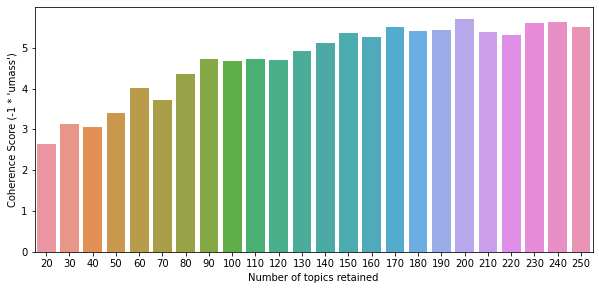

In [62]:
fig = plt.figure(figsize=(10, 4.5))
ax = fig.add_subplot(111)
sns.barplot(x=list(mf.keys()), y=[-1*score for score in mf.values()], ax=ax)
ax.set_xlabel("Number of topics retained")
ax.set_ylabel("Coherence Score (-1 * 'umass')")
plt.show()

In [108]:
best_mdl = tp.LDAModel.load("k_200")                             # step 1
td = pd.DataFrame(                                                # step 2
    np.stack([doc.get_topic_dist() for doc in best_mdl.docs]),
    columns=["topic_{}".format(i + 1) for i in range(best_mdl.k)],
)
td.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5082 entries, 0 to 5081
Data columns (total 200 columns):
 #    Column     Non-Null Count  Dtype  
---   ------     --------------  -----  
 0    topic_1    5082 non-null   float32
 1    topic_2    5082 non-null   float32
 2    topic_3    5082 non-null   float32
 3    topic_4    5082 non-null   float32
 4    topic_5    5082 non-null   float32
 5    topic_6    5082 non-null   float32
 6    topic_7    5082 non-null   float32
 7    topic_8    5082 non-null   float32
 8    topic_9    5082 non-null   float32
 9    topic_10   5082 non-null   float32
 10   topic_11   5082 non-null   float32
 11   topic_12   5082 non-null   float32
 12   topic_13   5082 non-null   float32
 13   topic_14   5082 non-null   float32
 14   topic_15   5082 non-null   float32
 15   topic_16   5082 non-null   float32
 16   topic_17   5082 non-null   float32
 17   topic_18   5082 non-null   float32
 18   topic_19   5082 non-null   float32
 19   topic_20   5082 non-null 

/var/folders/w3/c05dgb3x27z96j4wrkrgvn380000gn/T/ipykernel_2532/131340032.py:6: FutureWarning: null_counts is deprecated. Use show_counts instead
  td.info(verbose=True, null_counts=True)


In [64]:
from rich.console import Console
from rich.table import Table

In [65]:
# inspect the output of the LDA algorithm

# create a Rich's table to print the output of the spaCy's pipeline
console = Console()
# defin table properties
table = Table(
    show_header=True,
    header_style="cyan",
    title="[bold] [cyan] Word to topic probabilities (top 10 words)[/cyan]",
    width=150,
)
# add columns
table.add_column("Topic", justify="center", style="cyan", width=10)
table.add_column("W 1", width=12)
table.add_column("W 2", width=12)
table.add_column("W 3", width=12)
table.add_column("W 4", width=12)
table.add_column("W 5", width=12)
table.add_column("W 6", width=12)
table.add_column("W 7", width=12)
table.add_column("W 8", width=12)
table.add_column("W 9", width=12)
table.add_column("W 10", width=12)
# add rows
for k in range(best_mdl.k):
    values = []
    for word, prob in best_mdl.get_topic_words(k):
        values.append("{}\n({})\n".format(word, str(np.round(prob, 3))))       
    table.add_row(
        str(k),
        values[0],
        values[1],
        values[2],
        values[3],
        values[4],
        values[5],
        values[6],
        values[7],
        values[8],
        values[9],
    )
# print the table
table

                                                       Word to topic probabilities (top 10 words)                                                     
┏━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃   Topic   ┃ W 1         ┃ W 2         ┃ W 3         ┃ W 4         ┃ W 5        ┃ W 6         ┃ W 7        ┃ W 8         ┃ W 9        ┃ W 10        ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│     0     │ oldboy      │ revenge     │ korean      │ dae_su      │ scene      │ violence    │ man        │ hollywood   │ woo_jin    │ fight       │
│           │ (0.065)     │ (0.044)     │ (0.035)     │ (0.025)     │ (0.025)    │ (0.022)     │ (0.017)    │ (0.016)     │ (0.015)    │ (0.013)     │
│           │             │             │             │             │            │             │            │             │            │             │
│     1     │ dracula     │ box         │ moral       │ mark        │ button     │ beginning   │ pushed     │ earth       │ flopped    │ diaz        │
│           │ (0.033)     │ (0.03)      │ (0.028)     │ (0.022)     │ (0.017)    │ (0.017)     │ (0.017)    │ (0.014)     │ (0.011)    │ (0.011)     │
│           │             │             │             │             │            │             │            │             │            │             │
│     2     │ logic       │ plot        │ apocalypse  │ plot_holes  │ apparently │ spoiler     │ car        │ premise     │ wasn_t.    │ defying     │
│           │ (0.041)     │ (0.025)     │ (0.025)     │ (0.023)     │ (0.02)     │ (0.02)      │ (0.02)     │ (0.018)     │ (0.016)    │ (0.016)     │
│           │             │             │             │             │            │             │            │             │            │             │
│     3     │ wolf        │ leonard     │ death       │ fear        │ little     │ wolves      │ man        │ storm       │ men        │ chess       │
│           │ (0.037)     │ (0.034)     │ (0.025)     │ (0.025)     │ (0.023)    │ (0.023)     │ (0.021)    │ (0.021)     │ (0.021)    │ (0.021)     │
│           │             │             │             │             │            │             │            │             │            │             │
│     4     │ edward      │ susan       │ tony        │ gang        │ island     │ scooby_doo  │ revenge    │ news        │ jake_gyll… │ mystery     │
│           │ (0.1)       │ (0.089)     │ (0.039)     │ (0.034)     │ (0.018)    │ (0.016)     │ (0.013)    │ (0.013)     │ (0.013)    │ (0.011)     │
│           │             │             │             │             │            │             │            │             │            │             │
│     5     │ police      │ murder      │ crime       │ killer      │ murdered   │ killed      │ law        │ victims     │ innocent   │ wrong       │
│           │ (0.056)     │ (0.051)     │ (0.038)     │ (0.021)     │ (0.018)    │ (0.016)     │ (0.015)    │ (0.014)     │ (0.014)    │ (0.013)     │
│           │             │             │             │             │            │             │            │             │            │             │
│     6     │ kill        │ killed      │ wife        │ killing     │ dog        │ friends     │ gun        │ head        │ shoot      │ friend      │
│           │ (0.046)     │ (0.038)     │ (0.026)     │ (0.024)     │ (0.022)    │ (0.022)     │ (0.022)    │ (0.019)     │ (0.018)    │ (0.018)     │
│           │             │             │             │             │            │             │            │             │            │             │
│     7     │ music       │ songs       │ song        │ singing     │ musical    │ dance       │ sing       │ band        │ sound      │ voice       │
│           │ (0.117)     │ (0.048)     │ (0.043)     │ (0.031)     │ (0.0

In [123]:
from sklearn.model_selection import train_test_split
s0 = pd.merge(s, td, left_index = True, right_index = True)
X, y = s0.iloc[:,2:].values, s0.loc[:, "helpfulness_cat"].values
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.5,
    random_state=0
)

In [121]:
# scale the variables
from sklearn import MinMaxScaler
scaler = MinMaxScaler()
def scaler(df):
    # Scale values by row
    scaled_profile_feat = pd.DataFrame(scaler.fit_transform(df.iloc[:, 1:].T).T, columns=features)
    # Scale values by column
    scaled_profile_feat = pd.DataFrame(scaler.fit_transform(scaled_profile_feat), columns=features)
    # append scaled columns back to the dataframe
    df_pca[features] = scaled_profile_feat
    df_pca

,review_length,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,...,topic_191,topic_192,topic_193,topic_194,topic_195,topic_196,topic_197,topic_198,topic_199,topic_200
5,166,0.000584,0.000268,0.000521,0.000297,0.000277,0.001222,0.001879,0.001371,0.000919,...,0.000452,0.000819,0.001457,0.005391,0.008189,0.000584,0.000438,0.000956,0.002583,0.000505
6,154,0.000282,0.000129,0.000252,0.000143,0.000133,0.000590,0.042856,0.000662,0.070359,...,0.000218,0.000395,0.000703,0.002602,0.003952,0.000282,0.000211,0.000461,0.001247,0.000244
10,106,0.000683,0.000314,0.000610,0.000347,0.000323,0.001429,0.002198,0.001603,0.001075,...,0.000529,0.000958,0.001704,0.006304,0.043457,0.000683,0.000512,0.001118,0.003021,0.000590
32,99,0.000822,0.000377,0.000734,0.000418,0.000389,0.001720,0.002646,0.001930,0.001295,...,0.000637,0.001154,0.002051,0.048380,0.052320,0.000822,0.000616,0.001346,0.003637,0.000711
33,149,0.000537,0.000247,0.000480,0.000273,0.000254,0.001124,0.001729,0.001261,0.000846,...,0.000416,0.000754,0.001340,0.004960,0.007534,0.000537,0.000403,0.000880,0.002377,0.000465
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1718,188,0.000205,0.000094,0.000183,0.000104,0.000097,0.000428,0.000658,0.000480,0.000322,...,0.000158,0.000287,0.000510,0.032341,0.013020,0.000205,0.000153,0.000335,0.000905,0.000177
1499,169,0.000683,0.000314,0.000610,0.000347,0.000323,0.001429,0.002198,0.001603,0.001075,...,0.000529,0.000958,0.001704,0.040185,0.043457,0.000683,0.000512,0.001118,0.003021,0.000590
1643,802,0.001221,0.000560,0.001090,0.000621,0.000578,0.002553,0.003928,0.002865,0.001922,...,0.000945,0.001712,0.003045,0.011266,0.017114,0.001220,0.000915,0.001998,0.005399,0.001055
1704,192,0.000391,0.000180,0.000349,0.000199,0.000185,0.000819,0.001259,0.000918,0.000616,...,0.000303,0.000549,0.000976,0.003612,0.005487,0.000391,0.000293,0.000641,0.001731,0.000338


In [87]:
from sklearn.linear_model import RidgeClassifier
ridge_c = RidgeClassifier(alpha=0.1, random_state=0, fit_intercept=False)
ridge_c.fit(X_train, y_train)
ridge_c.score(X_test, y_test)
y_pred = ridge_c.predict(X_test)

In [88]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.63      0.62      0.63      1271
         1.0       0.63      0.63      0.63      1270

    accuracy                           0.63      2541
   macro avg       0.63      0.63      0.63      2541
weighted avg       0.63      0.63      0.63      2541



### trying with BERTopic

In [51]:
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer


In [55]:
#train = train[:5000]
review = list(train.loc[:2500, 'imdb_user_review'])

In [56]:
vectorizer_model = CountVectorizer(stop_words="english")
model = BERTopic(language="english", n_gram_range=(1,2), vectorizer_model=vectorizer_model, verbose = True)

In [57]:
topics, probs = model.fit_transform(review)

Batches:   0%|          | 0/79 [00:00<?, ?it/s]

2022-07-13 16:25:17,238 - BERTopic - Transformed documents to Embeddings
2022-07-13 16:25:30,094 - BERTopic - Reduced dimensionality
2022-07-13 16:25:30,291 - BERTopic - Clustered reduced embeddings


In [58]:
model.get_topic_freq()

,Topic,Count
0,-1,1149
1,0,280
2,1,103
3,2,91
4,3,90
5,4,86
6,5,77
7,6,53
8,7,47
9,8,45


In [59]:
model.get_topic(-1)

[('film', 0.017342086566566085),
 ('movie', 0.015804353006645785),
 ('just', 0.010364676633944352),
 ('like', 0.01034409405927084),
 ('time', 0.009917479524317145),
 ('story', 0.008770036550213831),
 ('people', 0.008484552523555006),
 ('good', 0.008471368255035009),
 ('great', 0.008164135459056346),
 ('best', 0.007751230304743044)]

In [60]:
model.get_topic(0)

[('love', 0.017902635091802066),
 ('film', 0.014677814735126643),
 ('movie', 0.013838392974633669),
 ('gyunwoo', 0.012555966336347979),
 ('story', 0.012454586019125514),
 ('ennis', 0.01117871765805801),
 ('girl', 0.01028271140068162),
 ('just', 0.0098206518209366),
 ('man', 0.009768261989140855),
 ('jack', 0.009685859851620812)]

In [61]:
model.get_topic(1)

[('horror', 0.0362005099116577),
 ('film', 0.020361169421362145),
 ('halloween', 0.019462322367066312),
 ('movie', 0.01881644360037247),
 ('saw', 0.012297532109160651),
 ('just', 0.011954119912440815),
 ('house', 0.011832694568846955),
 ('good', 0.011732064142494648),
 ('think', 0.011395846909709642),
 ('like', 0.011268642496078379)]

In [62]:
freq = model.get_topic_info()
freq

,Topic,Count,Name
0,-1,1149,-1_film_movie_just_like
1,0,280,0_love_film_movie_gyunwoo
2,1,103,1_horror_film_halloween_movie
3,2,91,2_movie_like_plot_film
4,3,90,3_disney_animation_animated_toy
5,4,86,4_comedy_funny_movie_jokes
6,5,77,5_alien_aliens_ripley_film
7,6,53,6_samurai_japanese_cruise_kurosawa
8,7,47,7_u0085_western_west_leone
9,8,45,8_film_fellini_french_father


# model build

### naive bayesian classifier

In [89]:
X, y = td, s.loc[:, "helpfulness_cat"]
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.5,
    random_state=0
)

In [69]:
# build naive bayesian classifier
from sklearn.naive_bayes import MultinomialNB

In [90]:
mnb = MultinomialNB()
mnb.fit(X_train, y_train)

MultinomialNB()

In [91]:
# making predictions on the testing set
y_pred = mnb.predict(X_test)
 
# comparing actual response values (y_test) with predicted response values (y_pred)
from sklearn import metrics
print("Multinomial Naive Bayes model accuracy(in %):", metrics.accuracy_score(y_test, y_pred)*100)

Multinomial Naive Bayes model accuracy(in %): 65.52538370720188


In [92]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.65      0.67      0.66      1271
         1.0       0.66      0.64      0.65      1270

    accuracy                           0.66      2541
   macro avg       0.66      0.66      0.66      2541
weighted avg       0.66      0.66      0.66      2541



In [ ]:
y_pred = predict(X_test)

### neural network

### tensorflow

In [72]:
# import libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
import keras_tuner as kt

In [93]:
# split train dataset into train and validation dataset
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

In [94]:
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

(1778, 200)
(1778,)
(763, 200)
(763,)


In [95]:
# set up a basic deep learning model
#    Sequential model: one input and one output layer
model = keras.models.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=X_train.shape[1:]),
    keras.layers.Dense(32,activation='relu'),
    keras.layers.Dense(16,activation='relu'),
    keras.layers.Dense(1)
])
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['Acc'])
history = model.fit(X_train, y_train, epochs=30,
                   validation_data=(X_valid, y_valid))

Epoch 1/30
56/56 [==============================] - 1s 19ms/step - loss: 0.3290 - Acc: 0.5090 - val_loss: 0.2456 - val_Acc: 0.5387
Epoch 2/30
56/56 [==============================] - 0s 2ms/step - loss: 0.2397 - Acc: 0.5877 - val_loss: 0.2364 - val_Acc: 0.6239
Epoch 3/30
56/56 [==============================] - 0s 2ms/step - loss: 0.2246 - Acc: 0.6839 - val_loss: 0.2265 - val_Acc: 0.6212
Epoch 4/30
56/56 [==============================] - 0s 2ms/step - loss: 0.2081 - Acc: 0.6918 - val_loss: 0.2200 - val_Acc: 0.6553
Epoch 5/30
56/56 [==============================] - 0s 1ms/step - loss: 0.1938 - Acc: 0.7216 - val_loss: 0.2235 - val_Acc: 0.6330
Epoch 6/30
56/56 [==============================] - 0s 1ms/step - loss: 0.1872 - Acc: 0.7300 - val_loss: 0.2183 - val_Acc: 0.6579
Epoch 7/30
56/56 [==============================] - 0s 1ms/step - loss: 0.1804 - Acc: 0.7362 - val_loss: 0.2256 - val_Acc: 0.6461
Epoch 8/30
56/56 [==============================] - 0s 1ms/step - loss: 0.1743 - Acc: 0.7

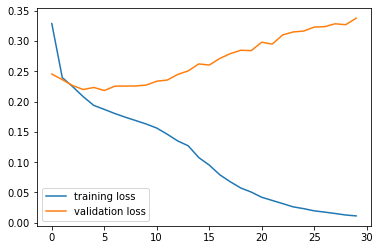

In [96]:
plt.plot(history.history['loss'],label = "training loss")
plt.plot(history.history['val_loss'], label = "validation loss")
plt.legend()
plt.show()

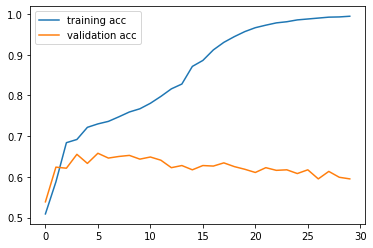

In [97]:
plt.plot(history.history['Acc'],label = "training acc")
plt.plot(history.history['val_Acc'], label = "validation acc")
plt.legend()
plt.show()

In [98]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.65      0.67      0.66      1271
         1.0       0.66      0.64      0.65      1270

    accuracy                           0.66      2541
   macro avg       0.66      0.66      0.66      2541
weighted avg       0.66      0.66      0.66      2541



### pytorch

In [ ]:
# load libraries
import torch
from torch.utils.data import DataLoader
# set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

In [ ]:
# convert train data to list with labels
train_data = []
for i in range(len(train)):
    train_data.append((int(train['helpfulness_cat'][i]), train['imdb_user_review'][i]))

In [ ]:
# check null values in train_data
null_count = 0
for i in range(len(train_data)):
    if train_data[i][0] == 'nan':
        null_count += 1
print("Null values in train_data:", null_count)


Null values in train_data: 0


In [ ]:
# convert train_data to iterator
train_data_iter = iter(train_data)

In [ ]:
# tokenization
tokenizer = get_tokenizer('basic_english')
# apply the tokenizer
# --+ custom function
def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)
# --+ deploy the tokenizer to get the vocabulary
vocab = build_vocab_from_iterator(yield_tokens(train_data_iter), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

In [ ]:
# tokenize Yelp reviews 
text_pipeline = lambda x: vocab(tokenizer(x))
# encode review labels
label_pipeline = lambda x: int(x)

In [ ]:
train_data_iter = iter(train_data)

In [ ]:
# custom function
def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for (_label, _text) in batch:
         label_list.append(label_pipeline(_label))
         processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
         text_list.append(processed_text)
         offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device)
# deploy the function
dataloader = DataLoader(train_data_iter, batch_size=8, shuffle=False, collate_fn=collate_batch)

In [ ]:
train_data_iter = iter(train_data)

In [ ]:
# %%
# model creation

# load libraries
from torch import nn
# the class associated with the module
class TextClassificationModel(nn.Module):

    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

In [ ]:
# %%
# model set up
train_data_iter = iter(train_data)
# examples
# classes
num_class = len(set([label for (label, text) in train_data_iter]))
# vocabulary size
vocab_size = len(vocab)
# ebedding bag size
emsize = 64
# model instantiation
model = TextClassificationModel(vocab_size, emsize, num_class).to(device)

In [ ]:
train_data_iter = iter(train_data)

In [ ]:
# load library 
import time
# custom function for training 
def train(dataloader):
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 500
    start_time = time.time()

    for idx, (label, text, offsets) in enumerate(dataloader):
        optimizer.zero_grad()
        predicted_label = model(text, offsets)
        loss = criterion(predicted_label, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        total_acc += (predicted_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches '
                  '| accuracy {:8.3f}'.format(epoch, idx, len(dataloader),
                                              total_acc/total_count))
            total_acc, total_count = 0, 0
            start_time = time.time()

In [ ]:
# custom function for evaluation
def evaluate(dataloader):
    model.eval()
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            predicted_label = model(text, offsets)
            loss = criterion(predicted_label, label)
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc/total_count

In [ ]:
train_data_iter = iter(train_data)

In [ ]:
# load libraries 
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset
# hyperparameters for the search
# --+ epoch
EPOCHS = 10 
# --+ learning rate
LR = 5  
# --+ batch size for training
BATCH_SIZE = 64 
# optimization
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
total_accu = None
# data handling
train_dataset = to_map_style_dataset(train_data_iter)
#test_dataset = to_map_style_dataset(test_iter)
num_train = int(len(train_dataset) * 0.95)
split_train_, split_valid_ = \
    random_split(train_dataset, [num_train, len(train_dataset) - num_train])

train_dataloader = DataLoader(split_train_, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
valid_dataloader = DataLoader(split_valid_, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
#test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                             #shuffle=True, collate_fn=collate_batch)

In [ ]:
# check the train_dataloader
for batch in train_dataloader:
    print(batch)
    break

(tensor([1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1,
        0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
        0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1]), tensor([  95,    6,   33,  ..., 1047,  152,    1]), tensor([    0,   176,   341,   355,   505,   550,   652,   819,  2021,  2685,
         2801,  3010,  3730,  3859,  4011,  4208,  4322,  4449,  4606,  4634,
         4990,  5317,  5911,  5936,  6703,  6815,  6887,  7031,  7459,  7711,
         7918,  8073,  8169,  8206,  8309,  8433,  8607,  8751,  8955,  9008,
         9105,  9241,  9382,  9549,  9561,  9577, 10450, 10863, 11005, 11034,
        11205, 11399, 11972, 12010, 12176, 12805, 12920, 12946, 13013, 13065,
        13109, 13231, 13382, 13627]))


In [ ]:
# logging
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train(train_dataloader)
    accu_val = evaluate(valid_dataloader)
    if total_accu is not None and total_accu > accu_val:
      scheduler.step()
    else:
       total_accu = accu_val
    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'valid accuracy {:8.3f} '.format(epoch,
                                           time.time() - epoch_start_time,
                                           accu_val))
    print('-' * 59)


-----------------------------------------------------------
| end of epoch   1 | time:  2.34s | valid accuracy    0.768 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   2 | time:  2.29s | valid accuracy    0.768 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   3 | time:  2.33s | valid accuracy    0.755 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   4 | time:  2.31s | valid accuracy    0.770 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   5 | time:  2.37s | valid accuracy    0.764 
-----------------------------------------------------------
-----------------------------------------------------------
| end of epoch   6 | time:  2.39s |

In [ ]:
# test on random unseen review

# labels
review_label = {1: "helpful",
                0: "unhelpful"}

def predict(text, text_pipeline):
    with torch.no_grad():
        text = torch.tensor(text_pipeline(text))
        output = model(text, torch.tensor([0]))
        return output.argmax(1).item() + 1

ex_text_str = "yes"

model = model.to("cpu")

print("This is a %s movie review" %review_label[predict(ex_text_str, text_pipeline)])

This is a helpful movie review
